# Python Notebook

In [1]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
import pandas as pd
# Change working directory to ConnectomeDB
project_root = "/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB"
os.chdir(project_root)
sys.path.append(os.path.abspath("src"))

In [2]:
import scanpy as sc
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import scanpy as sc
import re

output_dir = "data/tabula_sapiens/"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir +"umap" , exist_ok=True)
os.makedirs(output_dir +"heatmap" , exist_ok=True)

output_file = "data/tissue_dataset.h5ad"

if os.path.exists(output_file):
    # Do only if the file exists
    print("File exists. Proceeding with the task.")

    # Rest of the logic that should only run if file exists
else:
    url = "https://datasets.cellxgene.cziscience.com/9daa676b-07ec-4cea-80aa-daa49200aa64.h5ad"
    #Tabula Sapiens is a benchmark, first-draft human cell atlas of over 1.1M cells from 28 organs of 24 normal human subjects. This work is the product of the Tabula Sapiens Consortium. Taking the organs from the same individual controls for genetic background, age, environment, and epigenetic effects, and allows detailed analysis and comparison of cell types that are shared between tissues.
    # Get file size for progress bar
    response = requests.head(url)
    total_size = int(response.headers.get('Content-Length', 0))
    
    # Stream download with tqdm
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_file, 'wb') as f, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=output_file
        ) as pbar:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
                    
# Load with scanpy
adata = sc.read_h5ad(output_file)
print(adata)
print(adata.obs.columns) 
print(adata.var_names)    # Gene names


File exists. Proceeding with the task.
AnnData object with n_obs × n_vars = 1136218 × 61759
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism',

In [3]:
# normalize all data and log
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

KeyboardInterrupt: 

In [ ]:
#adata.write("data/tabula_sapiens/adata_processed.h5ad")

In [5]:
import pandas as pd
import re
from createDataTable import gene_pair0, pop_up_info

# Build HGNC-to-Ensembl mapping
ensembl_id = dict(zip(pop_up_info['HGNC ID'], pop_up_info['ensembl_gene_id']))

# Define HGNC ID extractor
def extract_hgnc_id(text):
    if pd.isna(text): return None
    match = re.search(r'(HGNC:\d+)', str(text))
    return match.group(1) if match else None

# --- Prepare ligand dataframe ---
ligand_df = gene_pair0[['Ligand', 'Ligand HGNC ID']].copy()
ligand_df.columns = ['gene_symbol', 'hgnc_id']  # Standardize column names

# --- Prepare receptor dataframe ---
receptor_df = gene_pair0[['Receptor', 'Receptor HGNC ID']].copy()
receptor_df.columns = ['gene_symbol', 'hgnc_id']

# Combine both
gene_pair_input = pd.concat([ligand_df, receptor_df], ignore_index=True)

# Extract clean HGNC IDs
gene_pair_input['hgnc_id'] = gene_pair_input['hgnc_id'].apply(extract_hgnc_id)

# Map to Ensembl IDs
gene_pair_input['ensembl_id'] = gene_pair_input['hgnc_id'].map(ensembl_id)

# Drop duplicates and NaNs if needed
gene_pair_input = gene_pair_input.drop_duplicates().dropna(subset=['ensembl_id'])

# Final output
print(gene_pair_input.head())


/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB/src/createDataTable.py:26: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")


  gene_symbol    hgnc_id       ensembl_id
0         A2M     HGNC:7  ENSG00000175899
2         ACE  HGNC:2707  ENSG00000159640
3         ADA   HGNC:186  ENSG00000196839
4      ADAM10   HGNC:188  ENSG00000137845
6      ADAM11   HGNC:189  ENSG00000073670


In [8]:
output_dir

'data/tabula_sapiens/'

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import plotly.express as px

# --- Setup output folders ---
os.makedirs(f"{output_dir}/heatmap", exist_ok=True)
os.makedirs(f"{output_dir}/umap", exist_ok=True)

# --- Annotation and UMAP coordinates ---
tissues = adata.obs["tissue"].astype(str).values
cell_types = adata.obs["cell_type"].astype(str).values
umap_coords = adata.obsm["X_umap"]

# --- Optional: Use .raw if available for faster, cleaner access ---
adata_use = adata.raw if adata.raw is not None else adata
X = adata_use.X.T  # Transpose to make column slicing fast

# --- Index lookup for genes ---
gene_id_list = gene_pair_input["ensembl_id"].tolist()
gene_label_map = dict(zip(gene_pair_input["ensembl_id"], gene_pair_input["gene_symbol"]))
gene_indices = {gene_id: i for i, gene_id in enumerate(adata_use.var_names)}

# --- Pre-extract expression ---
gene_expr_map = {}
for gene_id in gene_id_list:
    i = gene_indices[gene_id]
    x = X[i, :]  # slice row
    x = x.toarray().flatten() if hasattr(x, "toarray") else x.flatten()
    gene_expr_map[gene_id] = x

# --- Heatmap function ---
def generate_heatmap(gene_id):
    expr = gene_expr_map[gene_id]
    gene_label = gene_label_map[gene_id]

    df = pd.DataFrame({
        "expression": expr,
        "tissue": tissues,
        "cell_type": cell_types
    })
    pivot_df = df.groupby(["tissue", "cell_type"]).agg(
        mean_expression=("expression", "mean")
    ).reset_index()
    heatmap_data = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression")
    heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)
    height = max(300, len(heatmap_data.index) * 13)

    fig = px.imshow(
        heatmap_data,
        labels=dict(x="Tissue", y="Cell Type", color="Mean Expr"),
        x=heatmap_data.columns,
        y=heatmap_data.index,
        color_continuous_scale="Viridis",
        aspect="auto",
        title=f"{gene_label} Expression Across Tissues and Cell Types"
    )

    fig.update_layout(
        width=1000, height=height,
        xaxis_tickangle=45,
        xaxis=dict(tickfont=dict(size=8)),
        yaxis=dict(tickfont=dict(size=8))
    )

    fig.update_traces(
        zmin=np.nanmin(heatmap_data.values),
        zmax=np.nanmax(heatmap_data.values),
        hovertemplate="Tissue: %{x}<br>Cell type: %{y}<br>Expr: %{z:.2f}<extra></extra>"
    )

    fig.write_html(f"{output_dir}/heatmap/{gene_label}.html", include_plotlyjs="cdn")

# --- UMAP function ---
def generate_umap(gene_id):
    expr = gene_expr_map[gene_id]
    gene_label = gene_label_map[gene_id]

    df = pd.DataFrame({
        "UMAP1": umap_coords[:, 0],
        "UMAP2": umap_coords[:, 1],
        "expression": expr
    })

    fig = px.scatter(
        df, x="UMAP1", y="UMAP2", color="expression",
        color_continuous_scale="Viridis",
        title=f"{gene_label} Expression (UMAP)",
        labels={"expression": "Expression"}
    )

    fig.update_layout(coloraxis_colorbar=dict(title="Expr"), width=600, height=500)
    fig.write_html(f"{output_dir}/umap/{gene_label}.html", include_plotlyjs="cdn")

# --- Run Heatmaps in Parallel ---
Parallel(n_jobs=4)(
    delayed(generate_heatmap)(gene_id) for gene_id in tqdm(gene_id_list, desc="Plotting Heatmaps")
)

# --- Run UMAPs in Parallel ---
Parallel(n_jobs=4)(
    delayed(generate_umap)(gene_id) for gene_id in tqdm(gene_id_list, desc="Plotting UMAPs")
)


In [ ]:
from joblib import Parallel, delayed
import os
import pandas as pd
import numpy as np
import plotly.express as px

# Create output directory
os.makedirs(f"{output_dir}/heatmap", exist_ok=True)

# Pre-extract annotation data once
tissues = adata.obs["tissue"].astype(str).values
cell_types = adata.obs["cell_type"].astype(str).values

# Pre-extract expression data for all genes
all_expr = {}
for gene in gene_pair_input["ensembl_id"]:
    x = adata[:, gene].X
    all_expr[gene] = x.toarray().flatten() if hasattr(x, "toarray") else x.flatten()

# Function to create and save one heatmap
def generate_heatmap(gene, gene_label, expr):
    df = pd.DataFrame({
        "expression": expr,
        "tissue": tissues,
        "cell_type": cell_types
    })

    pivot_df = df.groupby(["tissue", "cell_type"]).agg(
        mean_expression=("expression", "mean")
    ).reset_index()

    heatmap_data = pivot_df.pivot(index="cell_type", columns="tissue", values="mean_expression")
    heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)
    height = max(300, len(heatmap_data.index) * 13)

    fig = px.imshow(
        heatmap_data,
        labels=dict(x="Tissue", y="Cell Type", color="Mean Expr"),
        x=heatmap_data.columns,
        y=heatmap_data.index,
        color_continuous_scale="Viridis",
        aspect="auto",
        title=f"{gene_label} Expression Across Tissues and Cell Types"
    )

    fig.update_layout(
        width=1000,
        height=height,
        xaxis_tickangle=45,
        xaxis=dict(tickfont=dict(size=8)),
        yaxis=dict(tickfont=dict(size=8))
    )

    fig.update_traces(
        zmin=np.nanmin(heatmap_data.values),
        zmax=np.nanmax(heatmap_data.values),
        hovertemplate="Tissue: %{x}<br>Cell type: %{y}<br>Expression: %{z:.2f}<extra></extra>",
        showscale=True,
        colorbar_title="Expression"
    )

    fig.write_html(f"{output_dir}/heatmap/{gene_label}.html", include_plotlyjs="cdn")

# Prepare inputs
tasks = [
    (gene, gene_pair_input["gene_symbol"].iloc[i], all_expr[gene])
    for i, gene in enumerate(gene_pair_input["ensembl_id"])
]

# Parallel run
Parallel(n_jobs=4)(
    delayed(generate_heatmap)(gene, label, expr) for gene, label, expr in tasks
)


In [ ]:
gene = genes[0]

# Build dataframe
df = pd.DataFrame(adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
df["expression"] = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X.flatten()
df["tissue"] = adata.obs["tissue"].astype(str).values  # ensure it’s an array
df["cell_type"] = adata.obs["cell_type"].astype(str).values  # ensure it’s an array
# Ensure `custom_data` is passed correctly as a list of columns
fig = px.scatter(
    df,
    x="UMAP1", y="UMAP2",
    color="expression",
    color_continuous_scale="viridis",
    title=f"{gene_name[0]} Expression on UMAP",
    width=600, height=600,
    render_mode="webgl",  # <-- faster for many points
    custom_data=["tissue", "cell_type"]  # required for hovertemplate
)

# Update hover to show tissue properly
fig.update_traces(
    marker=dict(size=3),
    hovertemplate="<br>".join([
        "Tissue: %{customdata[0]}",
        "Cell type: %{customdata[1]}",
        "Expression: %{marker.color:.2f}"
    ])
)
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title="Expr",
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False,
        title=None
    )
)


fig.show()
fig.write_html(f"{output_dir}/umap/{gene_name[0]}_UMAP.html", include_plotlyjs="cdn")

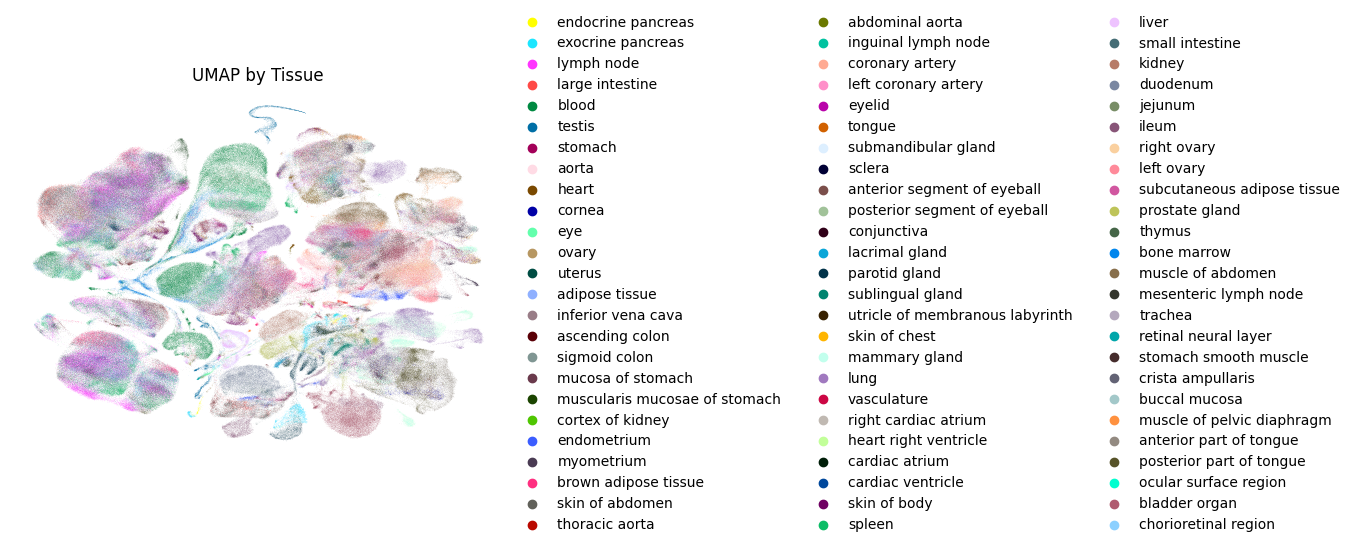

In [4]:
sc.pl.umap(
    adata,
    color='tissue',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Tissue',
    frameon=False
)


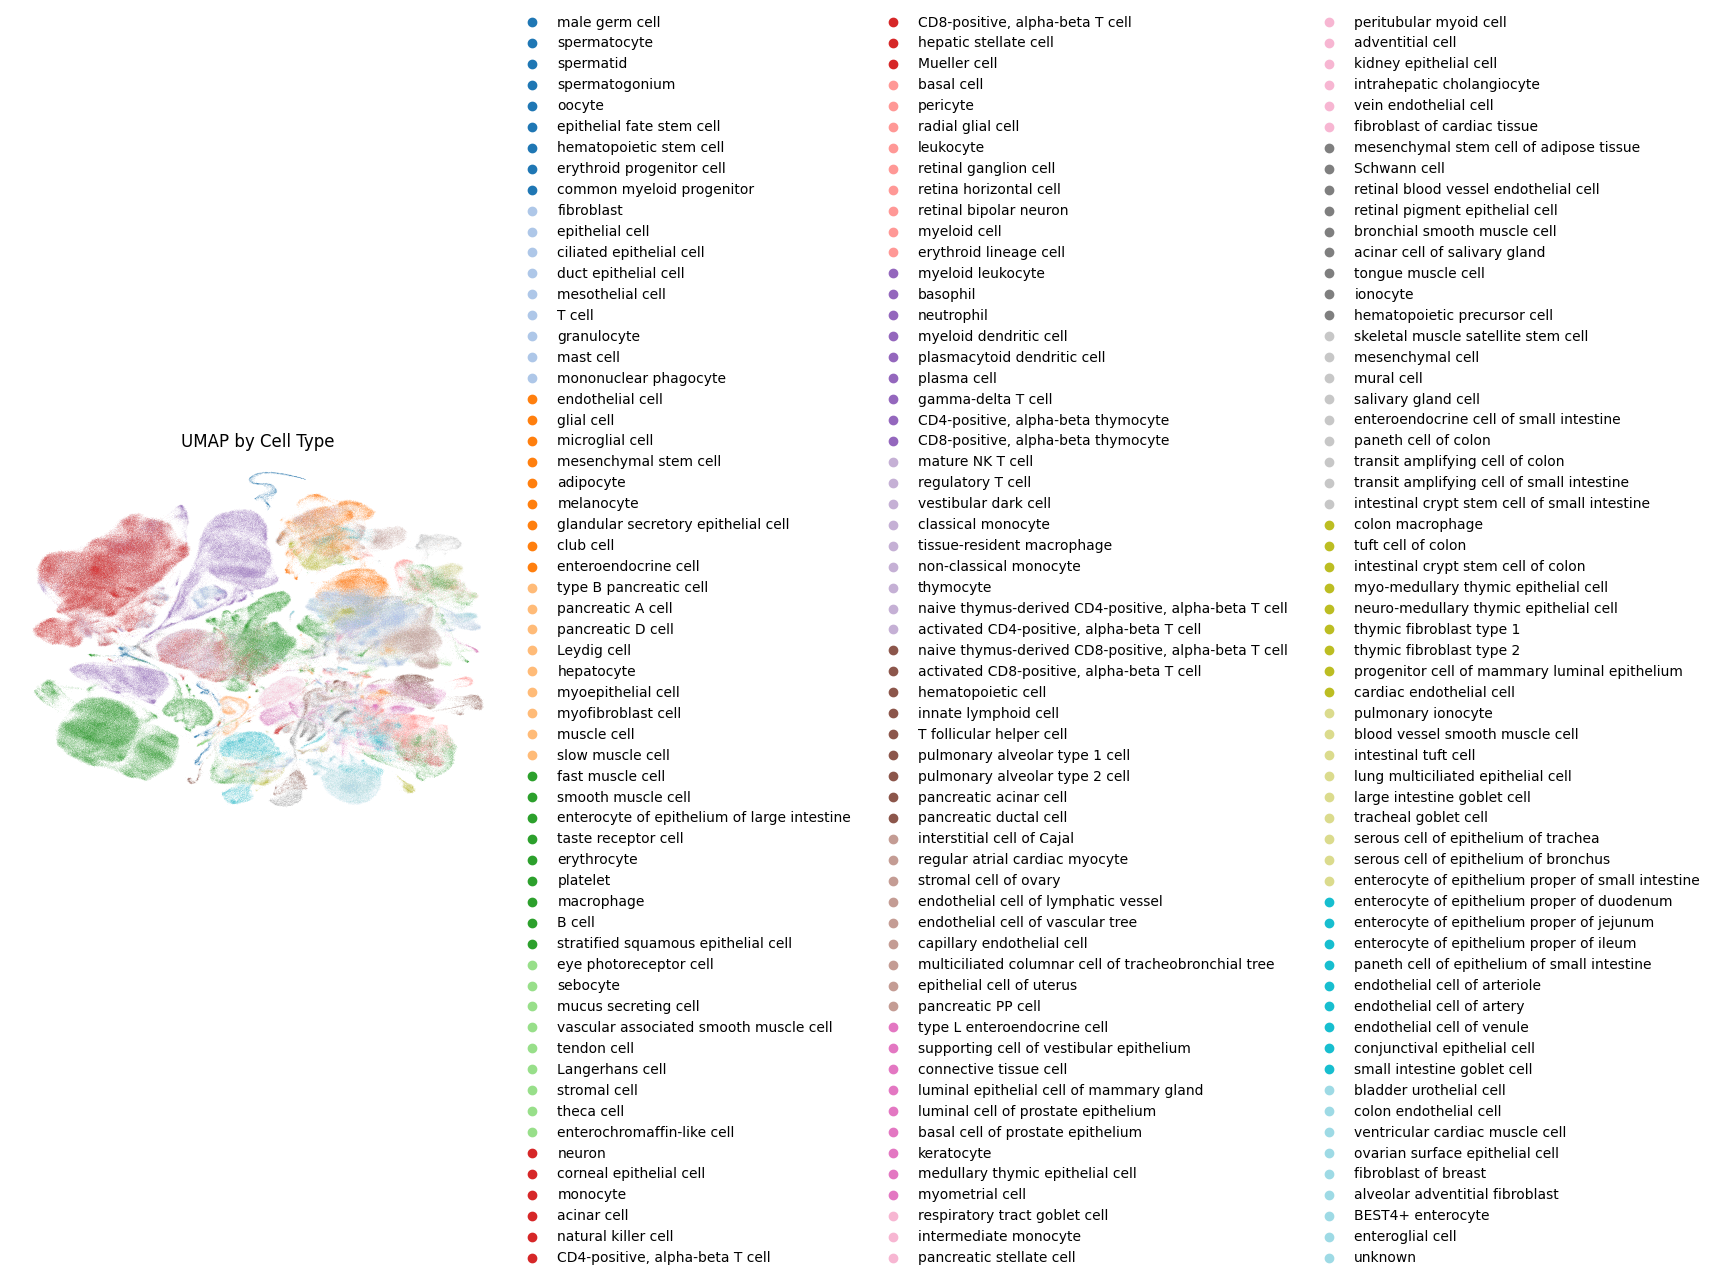

In [56]:
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='right margin',  # or 'right margin' for large datasets
    size=0.1,  # reduce for large datasets
    title='UMAP by Cell Type',
    frameon=False
)
